# Accessing NDBC Data
By Sage Lichtenwalner, March 31, 2020

In this notebook, we will demonstrate how to easily retrieve meteorological data from the [National Data Buoy Center](https://ndbc.noaa.gov) and calculate a daily average and anomaly.

In [1]:
# Notebook setup
import xarray as xr
!pip install netcdf4
import matplotlib.pyplot as plt

# This makes the plots prettier
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(8,6)})

# This removes an annoying warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Retrieving NDBC Data
NDBC's chief mission is to collect weather data to support the National Weather Service and its operational forecast models.  NDBC maintains a fleet of buoys and shore stations that collect a variety of atmospheric and oceanographic measurements.  In addition, they also serve as a data repository for a number of other partner observing systems, like IOOS.  With over 1000 stations all over the world, NDBC is a great resource for those looking to play with some ocean data.

The NDBC website provides some basic displays of recent data.  It also includes downloadable text files of archived data by year, which can be fun to play with in Excel (though not if you want to aggregate a number of different years or stations).

Thankfully, NDBC also provides a [DODS](https://dods.ndbc.noaa.gov) service (aka THREDDS or OPeNDAP) that makes it easy to access their full archive of netcdf data files, which is perfect for programming.

In general, the *Standard Meteorological data* files are the best place to start, as they include air and sea surface temperatures, winds, barometric pressure and waves.  The *Oceanographic data* stations are more relevant to oceanographers, but only a few stations are available

### How to find the right dataset URL
* From the NDBC DODS page, select the link for *stdmet*
* Click on the station you are interested in.  The NDBC homepage has a station map and search feature to help you find the right id.
* Next you will see a list of files for each year the buoy/station was deployed.  If you only want one year of data, you can select that year.  If you want real-time data, select the 9999 file.  If you would like the full aggregated archive, select the .ncml file.
* Click on the OPENDAP link.
* Copy the "Data URL" link, and paste that to your notebook.

For this example, I'll use my favorite buoy [44025](https://www.ndbc.noaa.gov/station_page.php?station=44025).  (Doesn't everyone have a favorite buoy?)

In [0]:
# The OPENDAP URL for the station we want
url = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44025/44025.ncml'

In [0]:
# Open the dataset using xarray, look how simple!
ds = xr.open_dataset(url)

In [4]:
# Quick list of available variaibles
ds.data_vars

Data variables:
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    mean_wave_dir            (time, latitude, longitude) float64 ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_temperature        (time, latitude, longitude) float32 ...
    visibility               (time, latitude, longitude) float32 ...
    water_level              (time, latitude, longitude) float32 ...

In [0]:
# Limit to last decade
ds = ds.sel(time=slice('2010-01-01', '2020-01-01'))

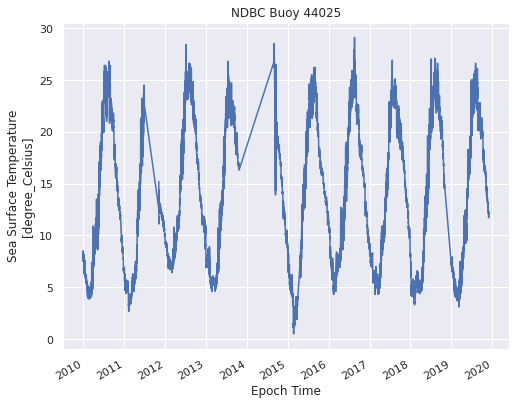

In [6]:
# Quickplot of SST
ds.sea_surface_temperature.plot()
plt.title('NDBC Buoy 44025');

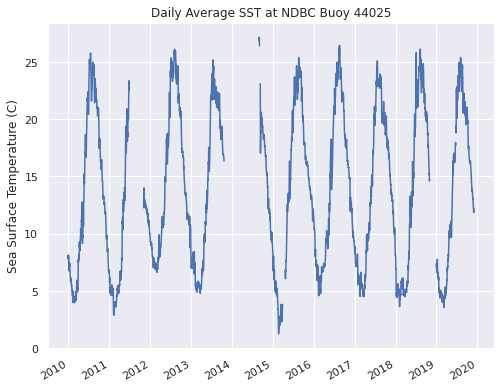

In [7]:
# Calculate and Plot Daily Average
daily_sst = ds.sea_surface_temperature.load().resample(time='1D').mean()
daily_sst.plot()
plt.title('Daily Average SST at NDBC Buoy 44025')
plt.xlabel('')
plt.ylabel('Sea Surface Temperature (C)');

## Calculating the Seasonal Cycle
Now that we have a decade of data, let's calculate a seasonal cycle which we can then use to calculate a daily anomaly measurement.

While xarray Datasets are great for accessing data, Pandas Dataframes provide a bit more functionality for this, so our first step will be to convert our Dataset to a Dataframe.

In [8]:
# Convert Dataset to Dataframe
df = ds.to_dataframe()
df = df.droplevel(['latitude','longitude']) # Drop extra indices that we don't need
df.head()

,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
time,,,,,,,,,,,,,
2010-01-01 00:50:00,45.0,4.3,5.5,0.54,00:00:02.940000,00:00:03.799999,11.0,1017.200012,4.5,7.8,3.2,NaN,NaN
2010-01-01 01:50:00,31.0,4.0,4.8,0.52,00:00:05,00:00:03.700000,176.0,1017.099976,4.5,7.8,3.3,NaN,NaN
2010-01-01 02:50:00,21.0,5.1,5.9,0.52,00:00:11.430000,00:00:03.970000,91.0,1016.500000,4.3,7.8,3.1,NaN,NaN
2010-01-01 03:50:00,18.0,3.6,4.4,0.57,00:00:12.119999,00:00:03.890000,86.0,1016.400024,4.2,8.0,2.9,NaN,NaN
2010-01-01 04:50:00,30.0,3.8,4.4,0.53,00:00:04.760000,00:00:03.980000,162.0,1015.500000,4.3,7.9,3.0,NaN,NaN


In [0]:
# Add a yearday column
df['yearday'] = df.index.dayofyear

In [0]:
# Calculate Annual Cycle
avg_sst = df.sea_surface_temperature.groupby(df.yearday).mean()

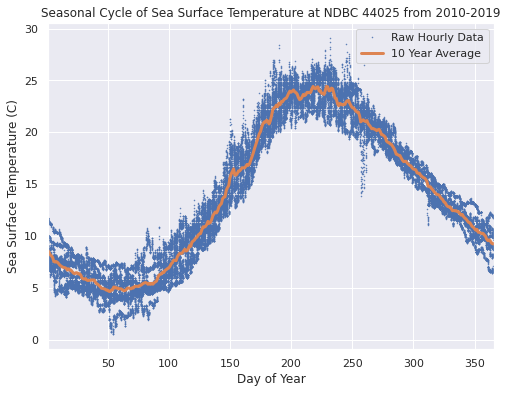

In [11]:
# Plot data by Yearday
plt.plot(df.yearday,df.sea_surface_temperature,'.',markersize=1,label='Raw Hourly Data');
avg_sst.plot(linewidth=3,label='10 Year Average')

plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Sea Surface Temperature (C)')
plt.title('Seasonal Cycle of Sea Surface Temperature at NDBC 44025 from 2010-2019');
plt.savefig('NDBC_44025_Seasonal_SST.png');

## Calculating the Anomoly
Now that we have calculated the 10-year average, we can use it to calculate a daily anomaly.

In [12]:
# Calculate daily average
df_daily = df.resample('1D').mean()
df_daily['yearday'] = df_daily.index.dayofyear
df_daily.head()

,wind_dir,wind_spd,gust,wave_height,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level,yearday
time,,,,,,,,,,,,
2010-01-01,188.125000,3.754167,4.808333,1.032083,151.208333,1013.016663,4.225000,7.837500,2.433333,NaN,NaN,1
2010-01-02,323.875000,11.941667,14.516666,1.713750,253.416667,1002.908325,1.270833,8.120833,-2.683333,NaN,NaN,2
2010-01-03,308.416667,17.129168,21.391666,3.278333,274.333333,997.883362,-3.433333,8.125000,-7.725000,NaN,NaN,3
2010-01-04,314.619048,12.719048,15.585714,2.050476,279.428571,1002.904785,-1.947619,7.761905,-6.719048,NaN,NaN,4
2010-01-05,313.500000,9.887500,12.262500,1.328333,286.750000,1005.691650,-1.391667,7.845833,-6.945833,NaN,NaN,5


In [0]:
# Calculate SST Anomoly based on the 10-year average
df_daily['sst_climate'] = avg_sst[df_daily.yearday].values
df_daily['sst_anomoly'] = df_daily['sea_surface_temperature'] - df_daily['sst_climate']

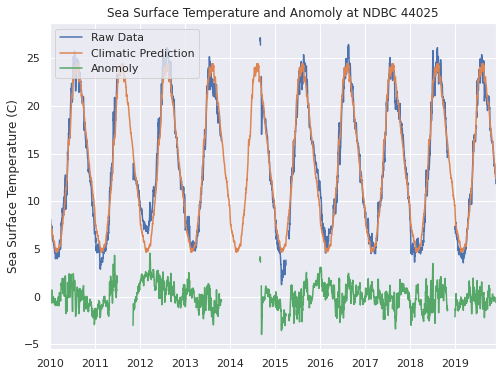

In [14]:
# Anomoly Plot
df_daily['sea_surface_temperature'].plot(label='Raw Data')
df_daily['sst_climate'].plot(label='Climatic Prediction')
df_daily['sst_anomoly'].plot(label='Anomoly')
plt.legend(loc='upper left');
plt.xlabel('')
plt.ylabel('Sea Surface Temperature (C)')
plt.title('Sea Surface Temperature and Anomoly at NDBC 44025');

## Recent SST Anomoly 
Finally, let's go back to the beginning, and instead of pulling 10 years of data, we will pull the last year and use the 10-year seasonal cycle to see what the anomaly looks like.

In [0]:
# Open the dataset and subset to the last 3 months
realtime = xr.open_dataset(url)
realtime = realtime.sel(time=slice('2019-01-01', '2020-04-01'))

# Convert to Dataframe
realtime = realtime.to_dataframe()
realtime = realtime.droplevel(['latitude','longitude']) # Drop extra indices

# Calculate daily average
realtime = realtime.resample('1D').mean()
realtime['yearday'] = realtime.index.dayofyear

# Add SST Anomoly based on the 10-year average
realtime['sst_climate'] = avg_sst[realtime.yearday].values
realtime['sst_anomoly'] = realtime['sea_surface_temperature'] - realtime['sst_climate']

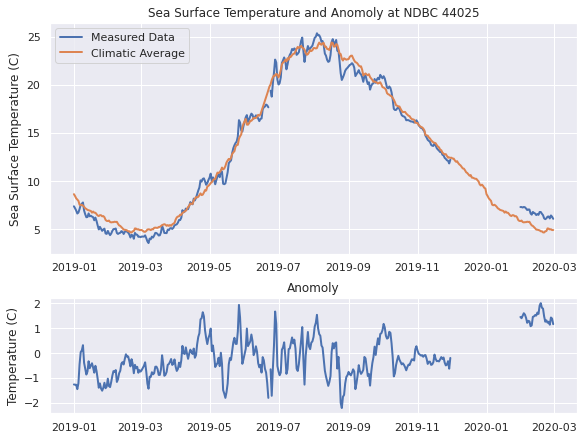

In [16]:
# Finally, let's plot it!
fig = plt.figure(constrained_layout=True)

# Rearrange the subplots so we have 1 big and 1 small graph
gs = plt.GridSpec(nrows=3,ncols=1, figure=fig)
ax1 = fig.add_subplot(gs[0:2])
ax2 = fig.add_subplot(gs[2:3])

ax1.plot(realtime['sea_surface_temperature'],linewidth=2,label='Measured Data')
ax1.plot(realtime['sst_climate'],linewidth=2,label='Climatic Average')
ax2.plot(realtime['sst_anomoly'],linewidth=2,label='Anomoly')

ax1.legend(loc='upper left');
ax1.set_ylabel('Sea Surface Temperature (C)')
ax1.set_title('Sea Surface Temperature and Anomoly at NDBC 44025');
ax2.set_ylabel('Temperature (C)')
ax2.set_title('Anomoly')
plt.savefig('NDBC_44025_SST_Anomoly.png');

Based on this, it looks like the ocean in the Mid-Atlantic was quite a bit warmer than average (around 1.5 degrees!) in February and March of 2020.  Last year at this time, temperatures were about 0.5 to 1 degree below the recent normal, though there was a lot of variability the rest of the year.